# **CS224W - Colab 5**

In this Colab we will experiment on scaling up GNNs using PyTorch Geometric, DeepSNAP and NetworkX. As we have **canceled** the Colab 5 assignment, this notebook will be a tutorial and you do not need to submit it on Gradescope.

At first, we will use PyTorch Geometric `NeighborSampler` to scale up the training and testing on OGB `arxiv` dataset.

Then, using the DeepSNAP and NetworkX, we will implement a simplified version of `NeighborSampler` and run experiments with different smapling ratios on the Cora graph.

At last, we will partition the Cora graph into clusters by using different partition algorithms and then train the models in the way of vanilla Cluster-GCN.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [3]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q ogb
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [4]:
import torch_geometric
torch_geometric.__version__

'1.7.0'

# 1 PyTorch Geometric Neighbor Sampling

Neighbor Sampling, originally proposed in **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)), is a representative method to scale up GNNs. As what we have learned in lecture, only a K-hop neighborhood nodes will be loaded into GPU for each time training. To further reduce the cost, we can sample a subset of neighborhood nodes for GNNs to aggregate.

## Setup

In [5]:
import copy
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.nn import SAGEConv
from torch_geometric.data import NeighborSampler
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## Neighbor Sampler

PyTorch Geometric has implemented the Neighbor Sampling method as the [NeighborSampler](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.NeighborSampler) in `torch_geometric.data`. Following is an example that uses the Neighbor Sampling method on training the OGB `arxiv` dataset.

If you are interested in memory-efficient aggregations, please refer to PyG's [Memory-Efficient Aggregations](https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html).

In [6]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())
data = dataset[0]
data.adj_t = data.adj_t.to_symmetric()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Device: {}'.format(device))

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

# Construct the training dataloader for training data
# Sample 10 neighbors for each node in the first layer and 5 for the second layer
train_loader = NeighborSampler(data.adj_t, node_idx=train_idx,
                               sizes=[10, 5], batch_size=4096,
                               shuffle=True, num_workers=2)

# Specify size as -1 to include all neighbors
all_loader = NeighborSampler(data.adj_t, node_idx=None, sizes=[-1],
                                  batch_size=4096, shuffle=False,
                                  num_workers=2)
evaluator = Evaluator(name='ogbn-arxiv')

Downloaded 0.00 GB:   1%|          | 1/81 [00:00<00:10,  7.45it/s]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:04<00:00, 17.47it/s]


Extracting dataset/arxiv.zip
Processing...
Loading necessary files...
This might take a while.


100%|██████████| 1/1 [00:00<00:00, 90.53it/s]

Processing graphs...
Converting graphs into PyG objects...
Saving...
Done!


Device: cuda


## GNN Model

After creating the `NeighborSampler`, we also need to modify the model to let it support the mini-batch training.

The `forward` function will take the node feature `x` and a list of three-element tuples `adjs`. Each element in `adjs` contains following elements:
* `edge_index`: The edge index tensor between source and destination nodes, which forms a bipartite grpah.
* `e_id`: The indices of the edges in the original graph.
* `size`: The shape of the bipartite graph, in (*number of source nodes*, *number of destination nodes*) format.

In [7]:
class SAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        for i in range(num_layers - 2):
            self.convs.append(
                SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, output_dim))

        self.softmax = torch.nn.LogSoftmax(dim=1)

        self.dropout = dropout

        self.num_layers = num_layers

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adjs, mode="batch"):
        if mode == "batch":
            for i, (edge_index, _, size) in enumerate(adjs):
                # Extract target node features
                x_target = x[:size[1]]

                # Update x for next layer reuse
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        else:
            for i, conv in enumerate(self.convs):
                x = conv(x, adjs)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        return self.softmax(x)
    
    def inference(self, x_all, all_loader):
        # This function will be called in test
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in all_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
                
                # Append the node embeddings to xs
                xs.append(x.cpu())
            
            # Concat all embeddings into one tensor
            x_all = torch.cat(xs, dim=0)

        return x_all

## Training and Testing

Now lets implement the training and testing functions.

In both training and testing, we need to sample batch from the dataloader.

Each batch in the `NeighborSampler` dataloader holds three elements:
* `batch_size`: The batch size specified in the dataloader.
* `n_id`: All nodes (in index format) used in the adjacency matrices.
* `adjs`: The three-element tuples.

In [8]:
def train(model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch"):
    model.train()

    total_loss = 0
    if mode == "batch":
        for batch_size, n_id, adjs in train_loader:
            # Move all adj sparse tensors to GPU
            adjs = [adj.to(device) for adj in adjs]
            optimizer.zero_grad()

            # Index on the node features
            out = model(data.x[n_id], adjs)
            train_label = data.y[n_id[:batch_size]].squeeze(-1)
            loss = loss_fn(out, train_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    else:
        optimizer.zero_grad()
        out = model(data.x, data.adj_t, mode=mode)[train_idx]
        train_label = data.y.squeeze(1)[train_idx]
        loss = loss_fn(out, train_label)
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

    return total_loss

@torch.no_grad()
def test(model, data, all_loader, split_idx, evaluator, mode="batch"):
    model.eval()

    if mode == "batch":
        out = model.inference(data.x, all_loader)
    else:
        out = model(data.x, data.adj_t, mode="all")

    y_true = data.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

## Mini-batch Training

In [9]:
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

batch_model = SAGE(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
batch_model.reset_parameters()

optimizer = torch.optim.Adam(batch_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_batch_model = None
best_valid_acc = 0

batch_results = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(batch_model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch")
    result = test(batch_model, data, all_loader, split_idx, evaluator, mode="batch")
    batch_results.append(result)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_batch_model = copy.deepcopy(batch_model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
best_result = test(best_batch_model, data, all_loader, split_idx, evaluator, mode="batch")
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 39.8755, Train: 62.85%, Valid: 64.29% Test: 64.48%
Epoch: 02, Loss: 28.5651, Train: 67.29%, Valid: 67.05% Test: 66.43%
Epoch: 03, Loss: 26.5543, Train: 68.97%, Valid: 68.53% Test: 68.07%
Epoch: 04, Loss: 25.6515, Train: 69.80%, Valid: 68.85% Test: 69.10%
Epoch: 05, Loss: 25.1170, Train: 69.49%, Valid: 68.09% Test: 66.53%
Epoch: 06, Loss: 24.6267, Train: 70.89%, Valid: 69.71% Test: 69.16%
Epoch: 07, Loss: 24.4057, Train: 71.27%, Valid: 69.45% Test: 68.61%
Epoch: 08, Loss: 23.9434, Train: 71.58%, Valid: 69.74% Test: 68.93%
Epoch: 09, Loss: 23.7608, Train: 72.15%, Valid: 69.51% Test: 68.02%
Epoch: 10, Loss: 23.5071, Train: 72.43%, Valid: 69.86% Test: 68.95%
Epoch: 11, Loss: 23.4053, Train: 72.56%, Valid: 70.35% Test: 69.52%
Epoch: 12, Loss: 23.1486, Train: 72.93%, Valid: 69.76% Test: 68.23%
Epoch: 13, Loss: 23.0137, Train: 73.10%, Valid: 70.03% Test: 68.80%
Epoch: 14, Loss: 22.8868, Train: 72.92%, Valid: 69.17% Test: 67.55%
Epoch: 15, Loss: 22.7737, Train: 73.24%, Valid: 

## Full-batch Training

In [10]:
# Use the same parameters for a full-batch training
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

all_model = SAGE(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
all_model.reset_parameters()

optimizer = torch.optim.Adam(all_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_all_model = None
best_valid_acc = 0

all_results = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(all_model, data, train_loader, train_idx, optimizer, loss_fn, mode="all")
    result = test(all_model, data, all_loader, split_idx, evaluator, mode="all")
    all_results.append(result)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_all_model = copy.deepcopy(all_model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
best_result = test(best_all_model, data, all_loader, split_idx, evaluator, mode="all")
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.8658, Train: 26.03%, Valid: 25.97% Test: 28.06%
Epoch: 02, Loss: 2.5288, Train: 32.84%, Valid: 37.77% Test: 38.79%
Epoch: 03, Loss: 2.1666, Train: 33.52%, Valid: 36.39% Test: 35.73%
Epoch: 04, Loss: 1.9868, Train: 34.49%, Valid: 37.70% Test: 36.91%
Epoch: 05, Loss: 1.8735, Train: 38.04%, Valid: 42.38% Test: 42.51%
Epoch: 06, Loss: 1.7819, Train: 42.60%, Valid: 48.20% Test: 49.59%
Epoch: 07, Loss: 1.7037, Train: 46.51%, Valid: 52.40% Test: 54.01%
Epoch: 08, Loss: 1.6398, Train: 49.88%, Valid: 55.08% Test: 56.42%
Epoch: 09, Loss: 1.5822, Train: 52.70%, Valid: 57.22% Test: 58.09%
Epoch: 10, Loss: 1.5302, Train: 55.11%, Valid: 59.06% Test: 59.36%
Epoch: 11, Loss: 1.4925, Train: 56.80%, Valid: 59.88% Test: 59.87%
Epoch: 12, Loss: 1.4649, Train: 57.90%, Valid: 60.50% Test: 60.06%
Epoch: 13, Loss: 1.4382, Train: 58.83%, Valid: 61.02% Test: 60.42%
Epoch: 14, Loss: 1.4162, Train: 59.76%, Valid: 61.51% Test: 60.66%
Epoch: 15, Loss: 1.3852, Train: 60.65%, Valid: 62.15% Test: 61

## Visualization

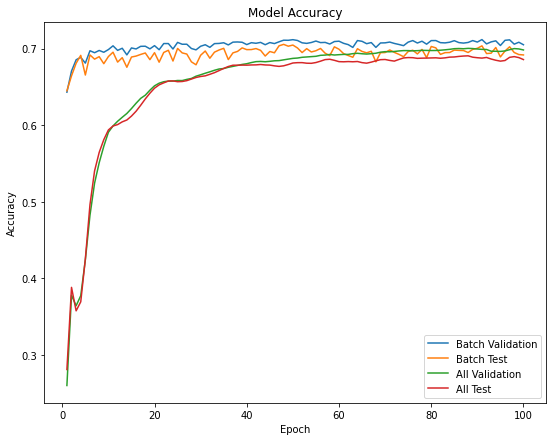

In [11]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_results)
all_results = np.array(all_results)

x = np.arange(1, 101)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 1], label="Batch Validation")
plt.plot(x, batch_results[:, 2], label="Batch Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 2 Neighbor Sampling with Different Ratios

Now we will implement a simplified version of Neighbor Sampling by using DeepSNAP and NetworkX, and train models with different neighborhood sampling ratios.

To make the experiments faster, we will use the Cora graph here.

## Setup

In [12]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./tmp', "Cora")

Processing...
Done!


## GNN Model

In [13]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNN, self).__init__()
        self.dropout = args['dropout']
        self.num_layers = args['num_layers']

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))

        for l in range(self.num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.post_mp = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, mode="batch"):
        if mode == "batch":
            edge_indices, x = data
            for i in range(len(self.convs) - 1):
                edge_index = edge_indices[i]
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_indices[len(self.convs) - 1])
        else:
            x, edge_index = data.node_feature, data.edge_index
            for i in range(len(self.convs) - 1):
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_index)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

## Neighbor Sampling

Here we implement functions that will sample neighbors by using DeepSNAP and NetworkX.

Notice that node classification task on Cora is a semi-supervised classification task, here we keep all the labeled training nodes (140 nodes) by setting the last ratio to 1.

In [14]:
def sample_neighbors(nodes, G, ratio, all_nodes):
    # This fuction takes a set of nodes, a NetworkX graph G and neighbor sampling ratio.
    # It will return sampled neighbors (unioned with input nodes) and edges between 
    neighbors = set()
    edges = []
    for node in nodes:
        neighbors_list = list(nx.neighbors(G, node))

        # We only sample the (ratio * number of neighbors) neighbors
        num = int(len(neighbors_list) * ratio)
        if num > 0:
            # Random shuffle the neighbors
            random.shuffle(neighbors_list)
            neighbors_list = neighbors_list[:num]
            for neighbor in neighbors_list:
                # Add neighbors
                neighbors.add(neighbor)
                edges.append((neighbor, node))
    return neighbors, neighbors.union(all_nodes), edges

def nodes_to_tensor(nodes):
    # This function transform a set of nodes to node index tensor
    node_label_index = torch.tensor(list(nodes), dtype=torch.long)
    return node_label_index

def edges_to_tensor(edges):
    # This function transform a set of edges to edge index tensor
    edge_index = torch.tensor(list(edges), dtype=torch.long)
    edge_index = torch.cat([edge_index, torch.flip(edge_index, [1])], dim=0)
    edge_index = edge_index.permute(1, 0)
    return edge_index

def relable(nodes, labeled_nodes, edges_list):
    # Relable the nodes, labeled_nodes and edges_list
    relabled_edges_list = []
    sorted_nodes = sorted(nodes)
    node_mapping = {node : i for i, node in enumerate(sorted_nodes)}
    for orig_edges in edges_list:
        relabeled_edges = []
        for edge in orig_edges:
            relabeled_edges.append((node_mapping[edge[0]], node_mapping[edge[1]]))
        relabled_edges_list.append(relabeled_edges)
    relabeled_labeled_nodes = [node_mapping[node] for node in labeled_nodes]
    relabeled_nodes = [node_mapping[node] for node in nodes]
    return relabled_edges_list, relabeled_nodes, relabeled_labeled_nodes

def neighbor_sampling(graph, K=2, ratios=(0.1, 0.1, 0.1)):
    # This function takes a DeepSNAP graph, K the number of GNN layers, and neighbor 
    # sampling ratios for each layer. This function returns relabeled node feature, 
    # edge indices and node_label_index

    assert K + 1 == len(ratios)

    labeled_nodes = graph.node_label_index.tolist()
    random.shuffle(labeled_nodes)
    num = int(len(labeled_nodes) * ratios[-1])
    if num > 0:
        labeled_nodes = labeled_nodes[:num]
    nodes_list = [set(labeled_nodes)]
    edges_list = []
    all_nodes = labeled_nodes
    for k in range(K):
        # Get nodes and edges from the previous layer
        nodes, all_nodes, edges = \
            sample_neighbors(nodes_list[-1], graph.G, ratios[len(ratios) - k - 2], all_nodes)
        nodes_list.append(nodes)
        edges_list.append(edges)
    
    # Reverse the lists
    nodes_list.reverse()
    edges_list.reverse()

    relabled_edges_list, relabeled_all_nodes, relabeled_labeled_nodes = \
        relable(all_nodes, labeled_nodes, edges_list)

    node_index = nodes_to_tensor(relabeled_all_nodes)
    # All node features that will be used
    node_feature = graph.node_feature[node_index]
    edge_indices = [edges_to_tensor(edges) for edges in relabled_edges_list]
    node_label_index = nodes_to_tensor(relabeled_labeled_nodes)
    log = "Sampled {} nodes, {} edges, {} labeled nodes"
    print(log.format(node_feature.shape[0], edge_indices[0].shape[1] // 2, node_label_index.shape[0]))
    return node_feature, edge_indices, node_label_index

## Training and Testing

In [15]:
def train(train_graphs, val_graphs, args, model, optimizer, mode="batch"):
    best_val = 0
    best_model = None
    accs = []
    graph_train = train_graphs[0]
    graph_train.to(args['device'])
    for epoch in range(1, 1 + args['epochs']):
        model.train()
        optimizer.zero_grad()
        if mode == "batch":
            node_feature, edge_indices, node_label_index = neighbor_sampling(graph_train, args['num_layers'], args['ratios'])
            node_feature = node_feature.to(args['device'])
            node_label_index = node_label_index.to(args['device'])
            for i in range(len(edge_indices)):
                edge_indices[i] = edge_indices[i].to(args['device'])
            pred = model([edge_indices, node_feature])
            pred = pred[node_label_index]
            label = graph_train.node_label[node_label_index]
        elif mode == "community":
            graph = random.choice(train_graphs)
            graph = graph.to(args['device'])
            pred = model(graph, mode="all")
            pred = pred[graph.node_label_index]
            label = graph.node_label[graph.node_label_index]
        else:
            pred = model(graph_train, mode="all")
            label = graph_train.node_label
            pred = pred[graph_train.node_label_index]
        loss = F.nll_loss(pred, label)
        loss.backward()
        optimizer.step()

        train_acc, val_acc, test_acc = test(val_graphs, model)
        accs.append((train_acc, val_acc, test_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * val_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')
    return best_model, accs

def test(graphs, model):
    model.eval()
    accs = []
    for graph in graphs:
        graph = graph.to(args['device'])
        pred = model(graph, mode="all")
        label = graph.node_label
        pred = pred[graph.node_label_index].max(1)[1]
        acc = pred.eq(label).sum().item()
        acc /= len(label)
        accs.append(acc)
    return accs

In [16]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 50,
    'ratios': (0.8, 0.8, 1),
}

## Full-Batch Training

In [17]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Epoch: 01, Loss: 2.0296, Train: 66.43%, Valid: 28.60% Test: 31.00%
Epoch: 02, Loss: 1.0734, Train: 91.43%, Valid: 49.60% Test: 52.00%
Epoch: 03, Loss: 0.6032, Train: 97.14%, Valid: 55.20% Test: 56.20%
Epoch: 04, Loss: 0.3066, Train: 100.00%, Valid: 58.80% Test: 60.00%
Epoch: 05, Loss: 0.1411, Train: 100.00%, Valid: 62.80% Test: 62.40%
Epoch: 06, Loss: 0.0727, Train: 100.00%, Valid: 64.80% Test: 64.40%
Epoch: 07, Loss: 0.0320, Train: 100.00%, Valid: 66.20% Test: 67.10%
Epoch: 08, Loss: 0.0271, Train: 100.00%, Valid: 68.20% Test: 68.80%
Epoch: 09, Loss: 0.0119, Train: 100.00%, Valid: 68.40% Test: 70.50%
Epoch: 10, Loss: 0.0132, Train: 100.00%, Valid: 69.80% Test: 70.80%
Epoch: 11, Loss: 0.0080, Train: 100.00%, Valid: 70.20% Test: 71.50%
Epoch: 12, Loss: 0.0052, Train: 100.00%, Valid: 70.60% Test: 72.30%
Epoch: 13, Loss: 0.0045, Train: 100.00%, Valid: 71.00% Test: 72.50%
Epoch: 14, Loss: 0.0

## Sampling with Ratios 0.8

In [18]:
args['ratios'] = (0.8, 0.8, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Sampled 1287 nodes, 1976 edges, 140 labeled nodes
Epoch: 01, Loss: 1.9884, Train: 30.71%, Valid: 12.60% Test: 13.00%
Sampled 1317 nodes, 1972 edges, 140 labeled nodes
Epoch: 02, Loss: 1.6395, Train: 63.57%, Valid: 17.20% Test: 19.90%
Sampled 1346 nodes, 2005 edges, 140 labeled nodes
Epoch: 03, Loss: 1.3103, Train: 82.86%, Valid: 24.40% Test: 29.10%
Sampled 1368 nodes, 2069 edges, 140 labeled nodes
Epoch: 04, Loss: 1.0506, Train: 95.00%, Valid: 33.20% Test: 33.50%
Sampled 1288 nodes, 1960 edges, 140 labeled nodes
Epoch: 05, Loss: 0.8372, Train: 97.14%, Valid: 39.60% Test: 38.30%
Sampled 1320 nodes, 1958 edges, 140 labeled nodes
Epoch: 06, Loss: 0.5567, Train: 97.86%, Valid: 44.60% Test: 42.90%
Sampled 1309 nodes, 1985 edges, 140 labeled nodes
Epoch: 07, Loss: 0.4460, Train: 98.57%, Valid: 47.80% Test: 45.10%
Sampled 1312 nodes, 1969 edges, 140 labeled nodes
Epoch: 08, Loss: 0.3365, Train: 

## Sampling with Ratios 0.3

In [19]:
# Change the ratio to 0.3
args['ratios'] = (0.3, 0.3, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs_1 = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Sampled 447 nodes, 238 edges, 140 labeled nodes
Epoch: 01, Loss: 1.9799, Train: 20.00%, Valid: 12.80% Test: 12.40%
Sampled 424 nodes, 242 edges, 140 labeled nodes
Epoch: 02, Loss: 1.9096, Train: 31.43%, Valid: 15.80% Test: 16.70%
Sampled 337 nodes, 137 edges, 140 labeled nodes
Epoch: 03, Loss: 1.8997, Train: 32.14%, Valid: 17.20% Test: 18.90%
Sampled 401 nodes, 208 edges, 140 labeled nodes
Epoch: 04, Loss: 1.8009, Train: 42.14%, Valid: 20.20% Test: 23.10%
Sampled 438 nodes, 260 edges, 140 labeled nodes
Epoch: 05, Loss: 1.8726, Train: 52.14%, Valid: 25.00% Test: 27.60%
Sampled 426 nodes, 235 edges, 140 labeled nodes
Epoch: 06, Loss: 1.8294, Train: 50.71%, Valid: 25.80% Test: 30.00%
Sampled 379 nodes, 185 edges, 140 labeled nodes
Epoch: 07, Loss: 1.7936, Train: 48.57%, Valid: 20.00% Test: 26.10%
Sampled 389 nodes, 191 edges, 140 labeled nodes
Epoch: 08, Loss: 1.6882, Train: 45.00%, Valid: 1

## Visualization

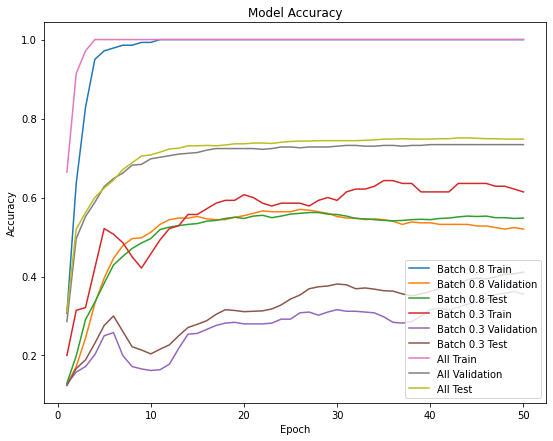

In [20]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_accs)
batch_results_1 = np.array(batch_accs_1)
all_results = np.array(all_accs)

x = np.arange(1, 51)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 0], label="Batch 0.8 Train")
plt.plot(x, batch_results[:, 1], label="Batch 0.8 Validation")
plt.plot(x, batch_results[:, 2], label="Batch 0.8 Test")
plt.plot(x, batch_results_1[:, 0], label="Batch 0.3 Train")
plt.plot(x, batch_results_1[:, 1], label="Batch 0.3 Validation")
plt.plot(x, batch_results_1[:, 2], label="Batch 0.3 Test")
plt.plot(x, all_results[:, 0], label="All Train")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Here all accuracies are evaluated on the full-batch mode.

# 3 Cluster Sampling

Instead of the neighbor sampling, we can use another approach, subgraph (cluster) sampling, to scale up GNN. This approach is proposed in Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953)).

In this section, we will implement vanilla Cluster-GCN and experiment with 3 different community partition algorithms.

Notice that this section requires you have run the `Setup`, `GNN Model` and `Training and Testing` cells of the last section.

## Setup

In [21]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import community as community_louvain

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./tmp', "Cora")

In [22]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 150,
}

## Partition the Graph into Clusters

Here we use following three community detection / partition algorithms to partition the graph into different clusters:
* [Kernighan–Lin algorithm (bisection)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)
* [Clauset-Newman-Moore greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)
* [Louvain algorithm](https://python-louvain.readthedocs.io/en/latest/api.html)


To make the training more stable, we discard the cluster that has less than 10 nodes.

Let's first define these algorithms as DeepSNAP transformation on a graph.

In [23]:
def preprocess(G, node_label_index, method="louvain"):
    graphs = []
    labeled_nodes = set(node_label_index.tolist())
    if method == "louvain":
        community_mapping = community_louvain.best_partition(G, resolution=10)
        communities = {}
        for node in community_mapping:
            comm = community_mapping[node]
            if comm in communities:
                communities[comm].add(node)
            else:
                communities[comm] = set([node])
        communities = communities.values()
    elif method == "bisection":
        communities = nx.algorithms.community.kernighan_lin_bisection(G)
    elif method == "greedy":
        communities = nx.algorithms.community.greedy_modularity_communities(G)

    for community in communities:
        nodes = set(community)
        subgraph = G.subgraph(nodes)
        # Make sure each subgraph has more than 10 nodes
        if subgraph.number_of_nodes() > 10:
            node_mapping = {node : i for i, node in enumerate(subgraph.nodes())}
            subgraph = nx.relabel_nodes(subgraph, node_mapping)
            # Get the id of the training set labeled node in the new graph
            train_label_index = []
            for node in labeled_nodes:
                if node in node_mapping:
                    # Append relabeled labeled node index
                    train_label_index.append(node_mapping[node])

            # Make sure the subgraph contains at least one training set labeled node
            if len(train_label_index) > 0:
                dg = Graph(subgraph)
                # Update node_label_index
                dg.node_label_index = torch.tensor(train_label_index, dtype=torch.long)
                graphs.append(dg)
    return graphs

## Louvain Preprocess

In [24]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="louvain")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 6 communities
Each community has 414 nodes in average
Each community has 819 edges in average


## Louvain Training

In [25]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
louvain_best_model, louvain_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], louvain_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.3405, Train: 12.14%, Valid: 15.00% Test: 12.40%
Epoch: 02, Loss: 2.0150, Train: 32.14%, Valid: 21.60% Test: 18.70%
Epoch: 03, Loss: 2.0600, Train: 40.00%, Valid: 20.40% Test: 20.70%
Epoch: 04, Loss: 1.1247, Train: 51.43%, Valid: 27.00% Test: 26.80%
Epoch: 05, Loss: 2.4934, Train: 54.29%, Valid: 33.60% Test: 34.20%
Epoch: 06, Loss: 0.7153, Train: 59.29%, Valid: 39.40% Test: 39.30%
Epoch: 07, Loss: 0.0596, Train: 68.57%, Valid: 41.40% Test: 42.60%
Epoch: 08, Loss: 0.3209, Train: 70.00%, Valid: 39.20% Test: 41.30%
Epoch: 09, Loss: 0.1807, Train: 72.14%, Valid: 37.20% Test: 38.30%
Epoch: 10, Loss: 0.0407, Train: 72.86%, Valid: 32.20% Test: 33.70%
Epoch: 11, Loss: 0.0361, Train: 75.00%, Valid: 30.80% Test: 31.80%
Epoch: 12, Loss: 0.1392, Train: 75.71%, Valid: 32.20% Test: 32.20%
Epoch: 13, Loss: 3.5642, Train: 80.71%, Valid: 32.80% Test: 33.10%
Epoch: 14, Loss: 0.0185, Train: 82.86%, Valid: 37.00% Test: 36.60%
Epoch: 15, Loss: 1.0461, Train: 87.14%, Valid: 39.80% Test: 39

## Bisection Preprocess

In [26]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="bisection")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 2 communities
Each community has 1354 nodes in average
Each community has 1415 edges in average


## Bisection Training

In [27]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
bisection_best_model, bisection_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], bisection_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.0310, Train: 33.57%, Valid: 36.60% Test: 41.30%
Epoch: 02, Loss: 1.1955, Train: 42.86%, Valid: 40.20% Test: 44.50%
Epoch: 03, Loss: 0.6865, Train: 60.00%, Valid: 43.60% Test: 48.00%
Epoch: 04, Loss: 0.3619, Train: 64.29%, Valid: 43.20% Test: 50.60%
Epoch: 05, Loss: 0.2499, Train: 64.29%, Valid: 43.60% Test: 51.60%
Epoch: 06, Loss: 0.1364, Train: 67.86%, Valid: 43.60% Test: 53.00%
Epoch: 07, Loss: 1.6444, Train: 74.29%, Valid: 48.80% Test: 57.20%
Epoch: 08, Loss: 0.0553, Train: 83.57%, Valid: 54.20% Test: 62.10%
Epoch: 09, Loss: 0.7969, Train: 92.86%, Valid: 61.00% Test: 66.70%
Epoch: 10, Loss: 0.4784, Train: 97.86%, Valid: 62.60% Test: 69.90%
Epoch: 11, Loss: 0.0321, Train: 99.29%, Valid: 65.40% Test: 70.70%
Epoch: 12, Loss: 0.0184, Train: 99.29%, Valid: 67.20% Test: 71.30%
Epoch: 13, Loss: 0.1548, Train: 99.29%, Valid: 68.20% Test: 71.60%
Epoch: 14, Loss: 0.0723, Train: 99.29%, Valid: 68.80% Test: 71.70%
Epoch: 15, Loss: 0.0268, Train: 99.29%, Valid: 69.60% Test: 72

## Greedy Preprocess

In [28]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="greedy")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 20 communities
Each community has 121 nodes in average
Each community has 222 edges in average


## Greedy Training

In [29]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
greedy_best_model, greedy_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], greedy_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.4290, Train: 10.71%, Valid: 8.80% Test: 10.50%
Epoch: 02, Loss: 2.1775, Train: 24.29%, Valid: 16.60% Test: 15.30%
Epoch: 03, Loss: 2.0181, Train: 27.86%, Valid: 12.40% Test: 13.70%
Epoch: 04, Loss: 2.2759, Train: 30.00%, Valid: 11.40% Test: 13.30%
Epoch: 05, Loss: 1.2065, Train: 31.43%, Valid: 9.80% Test: 11.30%
Epoch: 06, Loss: 2.5286, Train: 28.57%, Valid: 8.20% Test: 10.70%
Epoch: 07, Loss: 0.0468, Train: 26.43%, Valid: 7.40% Test: 9.30%
Epoch: 08, Loss: 3.1253, Train: 25.71%, Valid: 7.60% Test: 9.30%
Epoch: 09, Loss: 1.9669, Train: 25.71%, Valid: 7.60% Test: 9.30%
Epoch: 10, Loss: 2.8436, Train: 25.00%, Valid: 7.60% Test: 9.30%
Epoch: 11, Loss: 1.9471, Train: 25.71%, Valid: 8.00% Test: 9.90%
Epoch: 12, Loss: 2.8021, Train: 31.43%, Valid: 10.80% Test: 12.20%
Epoch: 13, Loss: 0.4417, Train: 37.14%, Valid: 14.20% Test: 15.60%
Epoch: 14, Loss: 1.2257, Train: 39.29%, Valid: 17.40% Test: 19.60%
Epoch: 15, Loss: 2.1954, Train: 42.86%, Valid: 17.60% Test: 21.00%
Epoch: 1

## Full-Batch Training

In [30]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Epoch: 01, Loss: 2.0021, Train: 47.86%, Valid: 22.80% Test: 20.80%
Epoch: 02, Loss: 1.1267, Train: 90.00%, Valid: 38.80% Test: 40.60%
Epoch: 03, Loss: 0.6480, Train: 99.29%, Valid: 54.00% Test: 54.80%
Epoch: 04, Loss: 0.3184, Train: 99.29%, Valid: 64.00% Test: 63.10%
Epoch: 05, Loss: 0.1610, Train: 99.29%, Valid: 68.80% Test: 68.00%
Epoch: 06, Loss: 0.0934, Train: 100.00%, Valid: 70.40% Test: 69.80%
Epoch: 07, Loss: 0.0337, Train: 100.00%, Valid: 70.60% Test: 71.00%
Epoch: 08, Loss: 0.0199, Train: 100.00%, Valid: 71.20% Test: 72.40%
Epoch: 09, Loss: 0.0192, Train: 100.00%, Valid: 71.00% Test: 73.40%
Epoch: 10, Loss: 0.0073, Train: 100.00%, Valid: 71.60% Test: 73.80%
Epoch: 11, Loss: 0.0086, Train: 100.00%, Valid: 71.40% Test: 74.10%
Epoch: 12, Loss: 0.0035, Train: 100.00%, Valid: 72.00% Test: 74.30%
Epoch: 13, Loss: 0.0014, Train: 100.00%, Valid: 72.00% Test: 74.40%
Epoch: 14, Loss: 0.001

## Visualization

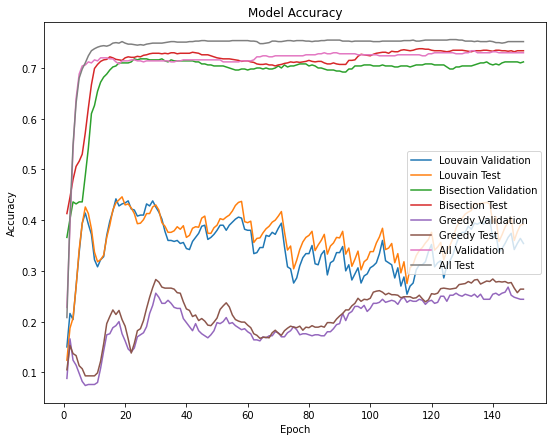

In [31]:
import numpy as np
from matplotlib import pyplot as plt

louvain_results = np.array(louvain_accs)
bisection_results = np.array(bisection_accs)
greedy_results = np.array(greedy_accs)
all_results = np.array(all_accs)

x = np.arange(1, 151)

plt.figure(figsize=(9, 7))

plt.plot(x, louvain_results[:, 1], label="Louvain Validation")
plt.plot(x, louvain_results[:, 2], label="Louvain Test")
plt.plot(x, bisection_results[:, 1], label="Bisection Validation")
plt.plot(x, bisection_results[:, 2], label="Bisection Test")
plt.plot(x, greedy_results[:, 1], label="Greedy Validation")
plt.plot(x, greedy_results[:, 2], label="Greedy Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()